In [1]:
#imports
import tensorflow as tf
from tensorflow.keras import Input, Model
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np
import util
import pickle
from random import randrange
import scipy
import math

# Generating Data

In [3]:
#generate random chord with 1-6 notes
maxNotes = 4
noise_power = 70 #add white noise

#22 = G2, 53 = D5    D5 freq = 587, G2 freq = 98   (limit freqs?)
lower = 22
upper = 53

#generate numcols random columns from a spectrogram, return (col(s), freqInterval, ans[])
def gencols(numcols):
    cols = []
    
    #pick a random number of notes
    numNotes = randrange(maxNotes) + 1
    notes = []
    
    #generate notes
    for i in range(numNotes):
        rand = randrange(upper - lower + 1) + lower
        while rand in notes:
            rand = randrange(upper - lower + 1) + lower
        notes.append(rand)
    
    #compile sounds
    sound = AudioSegment.from_file("pianomonoindexed/" + str(notes[0]) + ".mp3", format="mp3")
    for i in range(1, numNotes):
        soundnew = AudioSegment.from_file("pianomonoindexed/" + str(notes[i]) + ".mp3", format="mp3")
        #add a randomized decibel offset between -10 and 5
        offset = randrange(15) - 10
        soundnew += offset
        sound = sound.overlay(soundnew, position=0)

    data = np.array(sound.get_array_of_samples())
    noise = np.int_(np.round(np.random.normal(scale=100, size=len(data))))
    data += noise
    
    #generate spectrum
    #plt.specgram for visual spectrum (uses more time)
    #spectrum, freqs, times, dot = plt.specgram(np.array(sound.get_array_of_samples()), Fs=sound.frame_rate, NFFT=8192)
    #plt.show()
    #scipy.signal.spectrogram for without visual graph (save time)
    freqs, times, spectrum = scipy.signal.spectrogram(data, fs=sound.frame_rate, nperseg=8192)
    #with the current settings, spectrum = [4097, 2] (dimensions)
    
    #generate the answer array
    ans = []
    for i in range(upper - lower + 1):
        if (i + lower) in notes:
            ans.append(1)
        else:
            ans.append(0)
    
    if numcols == 1:
        randbool = randrange(1)
        return ([spectrum[:,randbool]], freqs[1], ans)
    else:
        return (np.transpose(spectrum), freqs[1], ans)

In [4]:
print(gencols(1))

([array([2.3385387e+01, 1.2346077e+02, 3.2617075e+02, ..., 1.9154586e-06,
       3.2036069e-06, 1.8870956e-06], dtype=float32)], 5.38330078125, [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


In [13]:
#data will have 1-6 note chords, only containing notes from G2 to D5 (inclusive)
numtrain = 20000
numtest = 500

minfreq = 95
maxfreq = 1200
numcolsPerSample = 1

folder = "trainingdata/"

def normalize(arr):
    return np.log10(arr)

0 train
50 train
100 train
150 train
200 train
250 train
300 train
350 train
400 train
450 train
500 train
550 train
600 train
650 train
700 train
750 train
800 train
850 train
900 train
950 train
1000 train
1050 train
1100 train
1150 train
1200 train
1250 train
1300 train
1350 train
1400 train
1450 train
1500 train
1550 train
1600 train
1650 train
1700 train
1750 train
1800 train
1850 train
1900 train
1950 train
2000 train
2050 train
2100 train
2150 train
2200 train
2250 train
2300 train
2350 train
2400 train
2450 train
2500 train
2550 train
2600 train
2650 train
2700 train
2750 train
2800 train
2850 train
2900 train
2950 train
3000 train
3050 train
3100 train
3150 train
3200 train
3250 train
3300 train
3350 train
3400 train
3450 train
3500 train
3550 train
3600 train
3650 train
3700 train
3750 train
3800 train
3850 train
3900 train
3950 train
4000 train
4050 train
4100 train
4150 train
4200 train
4250 train
4300 train
4350 train
4400 train
4450 train
4500 train
4550 train
4600 train


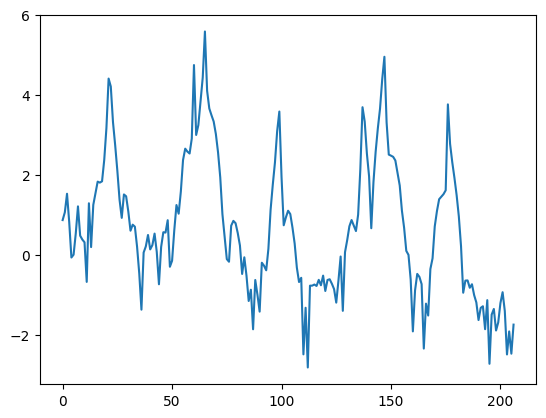

In [11]:
#create and serialize data
xtrain = []
ytrain = []
xtest = []
ytest = []


for i in range(math.ceil(numtrain/numcolsPerSample)):
    columns, basefreq, ans = gencols(numcolsPerSample)
    for col in columns:
        #trim the desired frequncies
        lowerindex = math.floor(minfreq/basefreq)
        upperindex = math.ceil(maxfreq/basefreq)
        xtrain.append(normalize(col[lowerindex:upperindex + 1]))
    ytrain.append(ans)
    if(i % 50 == 0): print(str(i) + " train")
    
for i in range(math.ceil(numtest/numcolsPerSample)):
    columns, basefreq, ans = gencols(numcolsPerSample)
    for col in columns:
        #trim the desired frequncies
        lowerindex = math.floor(minfreq/basefreq)
        upperindex = math.ceil(maxfreq/basefreq)
        xtest.append(normalize(col[lowerindex:upperindex + 1]))
    ytest.append(ans)
    if(i % 50 == 0): print(str(i) + " test")

    
pickle.dump(xtrain, open(folder + "xtrain.p", "wb"))
pickle.dump(ytrain, open(folder + "ytrain.p", "wb"))
pickle.dump(xtest, open(folder + "xtest.p", "wb"))
pickle.dump(ytest, open(folder + "ytest.p", "wb"))
plt.plot(xtrain[0])
print(ytrain[0])


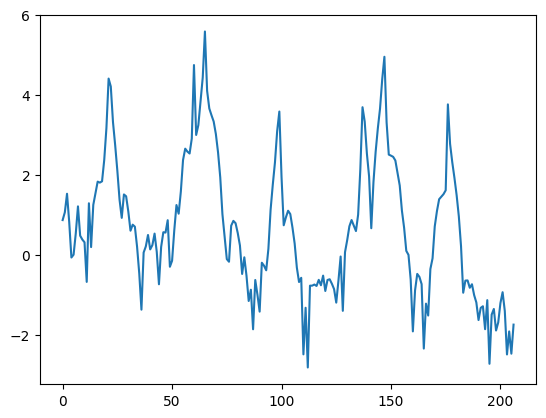

In [8]:
data = pickle.load(open(folder + "xtrain.p", "rb"))
plt.plot(data[0])

# Training

In [9]:
xtrain = np.array(pickle.load(open(folder + "xtrain.p", "rb")))
ytrain = np.array(pickle.load(open(folder + "ytrain.p", "rb")))
xtest = np.array(pickle.load(open(folder + "xtest.p", "rb")))
ytest = np.array(pickle.load(open(folder + "ytest.p", "rb")))

In [80]:
xtrain = tf.keras.utils.normalize(xtrain, axis=1)
xtest = tf.keras.utils.normalize(xtest, axis=1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(400, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(400, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(400, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.sigmoid))


model.compile(optimizer='adam', loss="mean_squared_error", metrics=['accuracy'])
model.fit(xtrain, ytrain, epochs=30)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0552 - loss: 0.0857
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6360 - loss: 0.0134
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6207 - loss: 0.0063
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5978 - loss: 0.0042
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5910 - loss: 0.0034
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5719 - loss: 0.0031
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5879 - loss: 0.0029
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5911 - loss: 0.0026
Epoch 9/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5962 - loss: 0.0021
Epoch 10/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6151 - loss: 0.0022
Epoch 11/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6308 - loss: 0.0019
Epoch 12/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [81]:
model.evaluate(xtest, ytest)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8022 - loss: 0.0032 


[0.0027826225850731134, 0.8140000104904175]

In [103]:
columns, basefreq, ans = gencols(1)
for col in columns:
    #trim the desired frequncies
    lowerindex = math.floor(minfreq/basefreq)
    upperindex = math.ceil(maxfreq/basefreq)
    example = normalize(col[lowerindex:upperindex + 1])

[a] = model.predict(np.array([example]))
rounded = np.int_(np.round(a))
for i in range(len(a)):
    # print (ans[i], a[i])
    if(rounded[i] == 1 and ans[i] == 1):
        print(util.numtokey(i), util.numtokey(i))
    elif rounded[i] == 1:
        print("--", util.numtokey(i), a[i])
    elif ans[i] == 1:
        print(util.numtokey(i), "--", a[i])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
f1 f1


# Identifying the chord

In [104]:
def is_subarray(A, B):
    n = len(A)
    m = len(B)
 
    for i in range(n - m + 1):
        for j in range(m):
            if A[i + j] != B[j]:
                break
        else:  
            return i
 
    return -1

qualities = [
    ([4, 4], "augmented triad"),
    ([4, 3], "major triad"),
    ([3, 4], "minor triad"),
    ([3, 3], "diminished triad"),
    ([4, 3, 4], "maj 7"),
    ([4, 3, 3], "7"),
    ([3, 4, 3], "min 7"),
    ([3, 3, 4], "half dim 7"),
    ([3, 3, 3], "dim 7")
]

ths = {
    1: "st",
    2: "nd",
    3: "rd"
}

intervals = {
    0: "perfect 8ve",
    1: "minor 2nd",
    2: "major 2nd",
    3: "minor 3rd",
    4: "major 3rd",
    5: "perfect 4th",
    6: "tritone",
    7: "perfect 5th",
    8: "minor 6th",
    9: "major 6th",
    10: "minor 7th",
    11: "major 7th",
}

# convert nn output to notes
def nn_output_to_notes(arr):
    res = []
    for i in range(len(arr)):
        if arr[i] > 0.5:
            res.append(i + lower)
    return res

#check the quality of a chord. for example, a major triad would be [4, 3]
# returns -1 if not, otherwise returns the inversion
# example: check_quality([50, 54, 57], [4, 3]) = 0 (0th inversion)
def check_quality(ch, difs):
    diffs = [*difs, 12 - sum(difs)]

    bass = min(ch)
    chord = sorted(list(set([(note - bass) % 12 for note in ch])))
    cdiffs = list(np.diff(chord))
    cdiffs.append(12 - sum(cdiffs))
    if len(cdiffs) != len(diffs):
        return -1
    diffs2 = [*diffs, *diffs]
    if (i := is_subarray(diffs2, cdiffs)) == -1:
        return -1
    return i


# converts note indices into chord (eg [10 14 17] -> major triad)
def notes_to_chord(ch):
    raw_chord = sorted(ch)
    #eliminiate octaves
    chord = []
    note_names = []
    for note in raw_chord:
        if note % 12 not in note_names:
            chord.append(note)
            note_names.append(note % 12)

    bass = chord[0]
    if len(ch) == 1:
        return f"{util.numtokey(bass)} (single note)"
    if len(ch) == 2:
        return f"{util.numtokey(bass)} {intervals[(chord[1] - chord[0]) % 12]}"

    inv_to_note = sorted(chord, key=lambda n: (n - bass) % 12)

    
    for (diffs, name) in qualities:
        if (i:= check_quality(chord, diffs)) >= 0:
            th = "th" if i not in ths else ths[i]
            return f"{util.numtokey(inv_to_note[-i])} {name}, {i}{th} inversion"
    return f"not identified: {[util.numtokey(note) for note in chord]}"


In [29]:
print(notes_to_chord([7, 3, 22, 10, 3 + 72]))

c1 major triad, 0th inversion


# Converting Real World Audio into Input

In [110]:
#change these two lines
audio_file = "realSamples/Cmaj.wav"
format = "wav"

sound = AudioSegment.from_file(audio_file, format="wav")
sound = sound.set_channels(1) # convert to mono
sound = sound[100:500] # trim to desired segment
file_handle = sound.export("realSamples/trimmed.mp3", format="mp3")

In [113]:
sound = AudioSegment.from_file("realSamples/trimmed.mp3", format="mp3")
data = np.array(sound.get_array_of_samples())

freqs, times, spectrum = scipy.signal.spectrogram(data, fs=sound.frame_rate, nperseg=8192)

lowerindex = math.floor(minfreq/basefreq)
upperindex = math.ceil(maxfreq/basefreq)
nn_input = normalize(spectrum[:,1][lowerindex:upperindex + 1])

[a] = model.predict(np.array([nn_input]))
for i in range(len(a)):
    if(a[i] > 0.99):
        print(util.numtokey(i + lower))

print()
print(notes_to_chord(nn_output_to_notes(a)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
e3
g3
e4
c5

c5 major triad, 1st inversion
